## SHOT CLASSIFICATION

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from classifier.shot_inference import ShotInference
import cv2

Using TensorFlow backend.


In [2]:
model_path = 'saved_model/shot_classifier'
image_path = 'testset/'
image_names = os.listdir(image_path)
label_path = 'testset/output_detection_info.csv'

shots = ['smash', 'drop', 'defense', 'backhand']
label = pd.read_csv(label_path, header=None)

inf_model = ShotInference(model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [10]:
classification_result = {}
cropped_frames = {}
for img in image_names:
    if img.endswith('png'):
        full_image_path = os.path.join(image_path, img)
        row = label.loc[label[0] == img]
        bbox = (row[2].values[0], row[3].values[0], row[4].values[0], row[5].values[0]) # xmin, ymin, xmax, ymax
        
        shot, frame = inf_model.predict(0, full_image_path, bbox)
        classification_result[img] = shot[0]
        cropped_frames[img] = frame

## POSE ESTIMATION

In [4]:
from open_pose_model.pose_predictor import Pose_predictor

C:\Users\swlee\Desktop\badminton-pose-analysis


In [5]:
pose_model_path = 'saved_model/keras_openpose_model.h5'
output_path = 'skeleton/'
pose_detector = Pose_predictor(pose_model_path)

C:\Users\swlee\Desktop\badminton-pose-analysis
{'param': {'use_gpu': '1', 'GPUdeviceNumber': '0', 'modelID': '1', 'octave': '3', 'starting_range': '0.8', 'ending_range': '2', 'scale_search': ['0.5', '1', '1.5', '2'], 'thre1': '0.1', 'thre2': '0.05', 'thre3': '0.5', 'min_num': '4', 'mid_num': '10', 'crop_ratio': '2.5', 'bbox_ratio': '0.25'}, 'models': {'1': {'caffemodel': './model/_trained_COCO/pose_iter_440000.caffemodel', 'deployFile': './model/_trained_COCO/pose_deploy.prototxt', 'description': 'COCO Pose56 Two-level Linevec', 'boxsize': '368', 'padValue': '128', 'np': '12', 'stride': '8', 'part_str': ['[nose', 'neck', 'Rsho', 'Relb', 'Rwri', 'Lsho', 'Lelb', 'Lwri', 'Rhip', 'Rkne', 'Rank', 'Lhip', 'Lkne', 'Lank', 'Leye', 'Reye', 'Lear', 'Rear', 'pt19]']}}}


start processing...
processing time is 6.95605
final all_peaks [[(242, 242), (364, 379), (349, 407)], [(260, 245), (233, 262), (374, 406)], [(248, 244), (228, 264), (380, 396)], [(244, 289), (398, 347)], [(268, 294), (396, 311)], [(273, 246), (239, 259), (367, 416)], [(258, 273), (389, 367)], [(260, 242), (270, 290), (395, 311)], [(241, 300), (421, 471)], [(276, 304), (464, 511)], [(278, 342), (496, 548)], [(254, 293), (399, 476)], [(284, 294), (372, 513)], [(283, 333), (326, 548)], [(239, 240), (359, 379)], [(260, 232), (244, 239), (347, 404)], [(230, 245), (358, 390)], [(266, 231), (351, 399)]]


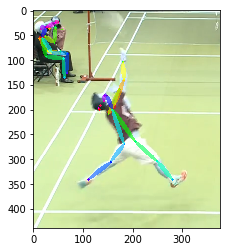

start processing...
processing time is 7.38725
final all_peaks [[], [(716, 364)], [(727, 372)], [(738, 391)], [(752, 397)], [(705, 357)], [(687, 364)], [(661, 368)], [(702, 409)], [(724, 405)], [(727, 444)], [(681, 403)], [(650, 440)], [(627, 475)], [], [], [(734, 354)], [(721, 346)]]


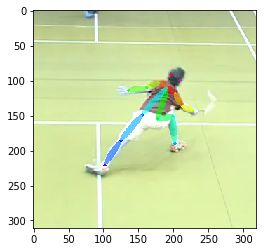

start processing...
processing time is 5.96492
final all_peaks [[(430, 360)], [(618, 170), (435, 389)], [(608, 170), (443, 377)], [(599, 193), (465, 338)], [(594, 211), (467, 298)], [(427, 400)], [], [(333, 170)], [(338, 172), (606, 207), (482, 442)], [(430, 170), (319, 179), (598, 227), (488, 407), (513, 474)], [(427, 192), (428, 193), (312, 203), (593, 257), (524, 515)], [(343, 177), (618, 208), (459, 449)], [(450, 170), (318, 179), (437, 493)], [(426, 193), (454, 193), (310, 204), (595, 254), (422, 529)], [(427, 361)], [], [(424, 371)], []]


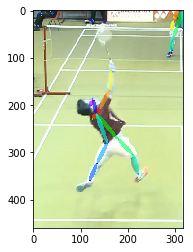

start processing...
processing time is 6.78108
final all_peaks [[(448, 411)], [(468, 438)], [(448, 436)], [(412, 444)], [(377, 445)], [(488, 441)], [(510, 471)], [(519, 503)], [(460, 498)], [(424, 521)], [(273, 342), (420, 578)], [(491, 506)], [(501, 556)], [(277, 341), (501, 564)], [], [(454, 409)], [(402, 679)], [(467, 416)]]


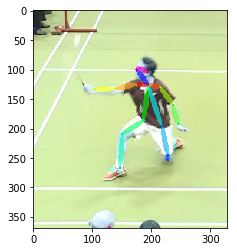

In [6]:
skeleton_frames = {}
for img in image_names:
    if img.endswith(".png"):
        full_image_path = os.path.join(image_path,img)
        result,skeleton_img = pose_detector.single_predictor(full_image_path,output_path,label_path)
        skeleton_frames[img] = result
        #skeleton_frames[img] = skeleton_img
        plt.imshow(skeleton_img)
        plt.show()

## HOMOGRAPHIC TRANSFORMATION

### Lunge Distance Calculation

In [7]:
from skeleton_matching.perspective_transform import PerspectiveTransform

unlabelled_TEST_Test1_4
lunge distance = 1.1506406348519551


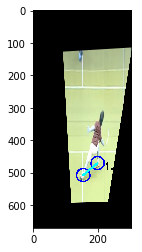

In [12]:
pt = PerspectiveTransform()

for img in image_names:
    if img.endswith(".png"):
        if(classification_result[img] == 1 or classification_result[img] == 2):
            full_image_path = os.path.join(image_path,img)
            wr_img = pt.warp_homography_perspective(full_image_path)

            sk_info = skeleton_frames[img]
            dist, wr_img2 = pt.get_lunge_distance2(full_image_path, sk_info)

            plt.imshow(wr_img2)
            print("lunge distance =",dist)
            plt.show()

### Angle Calculations